In [75]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
from einops import rearrange
from path import Path
from typing import Optional
import random, math
from functools import partial
from tqdm import tqdm

import fastcore.all as fc
from miniai.learner import *
from miniai.datasets import *
from miniai.init import *
from miniai.sgd import *

from torcheval.metrics import MulticlassAccuracy,Mean

import pdb

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# for reproducibility
RANDOM_SEED = 10
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

### Baby-Llama
**Architecture includes**
- RMSNorm (hypothesizes that variance normalization speeds up training, zero mean not required, hence less parameter)
- ROPE (Rotational positional embedding)
- Grouped Multi-Query <br>

**Inference**
- Using KV cache
- top-p sampler

### We will train it on Entire Shakespare

In [4]:
with open("../Datasets/EntireShakespare.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [5]:
len(text)

5376450

In [6]:
total_size = len(set(text))
print(f"total vocab size: {total_size}")

total vocab size: 105


In [7]:
# first 1000 characters
text[:1000]

'THE SONNETS\n\n                    1\n\nFrom fairest creatures we desire increase,\nThat thereby beauty’s rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed’st thy light’s flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThyself thy foe, to thy sweet self too cruel:\nThou that art now the world’s fresh ornament,\nAnd only herald to the gaudy spring,\nWithin thine own bud buriest thy content,\nAnd, tender churl, mak’st waste in niggarding:\n  Pity the world, or else this glutton be,\n  To eat the world’s due, by the grave and thee.\n\n\n                    2\n\nWhen forty winters shall besiege thy brow,\nAnd dig deep trenches in thy beauty’s field,\nThy youth’s proud livery so gazed on now,\nWill be a tattered weed of small worth held:\nThen being asked, where all thy beauty lies,\nWhere all the treasure of thy lusty days;\nTo say, within thine own deep sun

In [8]:
chars = sorted(list(set(text)))
vocabsize = len(chars)
print("".join(chars))
print(vocabsize)

	
 !$%&'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyzÀÆÇÉàâæçèéêëîœ—‘’“”•…™
105


In [9]:
chars[0:5]

['\t', '\n', ' ', '!', '$']

### Tokenize the text input
- Google uses sentencepiece as tokenizer (BPE - Byte pair encoding)
- OpenAI uses tiktoken
- We will just use character level tokenizer

In [10]:
# mapping from characters to integers and vice-versa
stoi = {char: i for i, char in enumerate(chars)}
itos = {i: char for i, char in enumerate(chars)}
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda s: [itos[i] for i in s]
print(encode("hey"))
print(decode(encode("hey")))

[64, 61, 81]
['h', 'e', 'y']


### Build dataset

In [11]:
# split the train/val text
n = int(0.9*len(text))
train_data = text[0:n]
val_data = text[n:]
print(f"train_len:{len(train_data)}, val_len:{len(val_data)}")

train_len:4838805, val_len:537645


In [12]:
class Tokenizer():
    def __init__(self, data):
        self.data = data
        self.vocab = sorted(list(set(self.data)))
        
        self.stoi = {char:i for i,char in enumerate(self.vocab)}
        self.itos = {i:char for i,char in enumerate(self.vocab)}

        self.pad_id = torch.tensor(-1, dtype=torch.long)

    def encode(self, s: str) -> list[int]:
        return [self.stoi[ch] for ch in s]

    def decode(self, ii:list[int]) -> list[str]:
        return [self.itos[i] for i in ii]

    @property
    def vocabsize(self):
        return len(self.stoi)

    @property
    def encoder(self):
        return self.stoi

    @property
    def decoder(self):
        return self.itos

In [13]:
tokenizer = Tokenizer(text)
print(tokenizer.vocabsize)
print(tokenizer.stoi)
print(tokenizer.itos)

105
{'\t': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '?': 27, 'A': 28, 'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37, 'K': 38, 'L': 39, 'M': 40, 'N': 41, 'O': 42, 'P': 43, 'Q': 44, 'R': 45, 'S': 46, 'T': 47, 'U': 48, 'V': 49, 'W': 50, 'X': 51, 'Y': 52, 'Z': 53, '[': 54, ']': 55, '_': 56, 'a': 57, 'b': 58, 'c': 59, 'd': 60, 'e': 61, 'f': 62, 'g': 63, 'h': 64, 'i': 65, 'j': 66, 'k': 67, 'l': 68, 'm': 69, 'n': 70, 'o': 71, 'p': 72, 'q': 73, 'r': 74, 's': 75, 't': 76, 'u': 77, 'v': 78, 'w': 79, 'x': 80, 'y': 81, 'z': 82, 'À': 83, 'Æ': 84, 'Ç': 85, 'É': 86, 'à': 87, 'â': 88, 'æ': 89, 'ç': 90, 'è': 91, 'é': 92, 'ê': 93, 'ë': 94, 'î': 95, 'œ': 96, '—': 97, '‘': 98, '’': 99, '“': 100, '”': 101, '•': 102, '…': 103, '™': 104}
{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '$', 5: '%', 6:

In [14]:
class chardataset(Dataset):
    
    def __init__(self, data, tokenizer):
        super().__init__()
        self.text = data
        self.tokenizer = tokenizer
        self.tokens = self.tokenizer.encode(self.text)
        self.text_len = len(data)
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index: int):
        X = torch.tensor(self.tokens[index])
        y = torch.tensor(self.tokens[index+1])
        return X,y
    

In [15]:
train_dataset = chardataset(train_data, tokenizer)
val_dataset =chardataset(val_data, tokenizer)
print(len(train_dataset), len(val_dataset))

4838805 537645


In [16]:
X, y = train_dataset[0]
print(X,y)
X, y = train_dataset[1]
print(X,y)
X, y = train_dataset[2]
print(X,y)
X, y = train_dataset[3]
print(X,y)

tensor(47) tensor(35)
tensor(35) tensor(32)
tensor(32) tensor(2)
tensor(2) tensor(46)


In [17]:
''.join(tokenizer.decode([X.item()])), ''.join(tokenizer.decode([y.item()]))

(' ', 'S')

In [18]:
Xval, yval = val_dataset[0]
print(Xval, yval)

tensor(2) tensor(60)


### Build dataloaders

In [19]:
BATCH_SIZE = 32
SEQ_LEN = 256

In [20]:
#NOTE: do not shuffle in trainloader as it will generate random token pairs for input, label
def collate(b):
  '''
  b is tuple of lenght == batch size
  each element of b, i.e., b[0] is again a tuple (x,y)
  so b is like ((x0,y0), (x1,y1), (x2,y2), (x3,y3), ...)
  zip(*b): will zip it into ((x0,x1,x2,...),(y0,y1,y2,...))
  xs, ys = zip(*b) will do de-structuring such that
  xs = (x0,x1,x2,...)
  ys= (y0, y1, y2, ....)
  torch.stack(xs) will stack xs all together by adding new dimension to axis=0 by default
  similarly for torch.stack(ys)
  '''
  
  xs, ys = zip(*b)
  xs, ys = torch.tensor(xs), torch.tensor(ys) #<batch*seq_len>, #<batch*seq_len>
  xs = xs.reshape(-1, SEQ_LEN) #<batch, seq_len>
  ys = ys.reshape(-1, SEQ_LEN) #<batch, seq_len>
  return xs,ys
    
trainloader = DataLoader(dataset = train_dataset, 
                         batch_size = BATCH_SIZE * SEQ_LEN, 
                         shuffle = False,
                         collate_fn = collate
                        )

valloader = DataLoader(dataset = val_dataset, 
                       batch_size = BATCH_SIZE * SEQ_LEN, 
                       shuffle = False,
                       collate_fn = collate
                      )

# NOTE: there is an issue while creating dataloader this way, lets say text has L tokens, so when it reaches the last token, 
# there is no corresponding label for that token
# So, one way to deal with that is to write our own sampler and pass it to dataloader class
# from pytorch doc, it could be iterable

class Sampler():
    def __init__(self, ds, context_window_len=512, shuffle=False):
        self.len_ds = len(ds)
        self.shuffle = shuffle
        self.context_window_len = context_window_len
        self.indices = list(range(0,self.len_ds-1)) # we will exclude the last token so that corresponding label can be generated in Dataset class

    def __iter__(self):
        if self.shuffle:
          random.shuffle(self.indices)
        return iter(self.indices)

    def __len__(self):
        return self.len_ds

train_sampler = Sampler(train_dataset, context_window_len = SEQ_LEN, shuffle=False)
val_sampler = Sampler(val_dataset, context_window_len = SEQ_LEN, shuffle=False)

# Now re-create data loaders
trainloader = DataLoader(dataset = train_dataset, 
                         batch_size = BATCH_SIZE * SEQ_LEN, 
                         sampler = train_sampler,
                         collate_fn = collate,
                         drop_last = True
                        )

valloader = DataLoader(dataset = val_dataset, 
                       batch_size = BATCH_SIZE * SEQ_LEN, 
                       sampler = val_sampler,
                       collate_fn = collate,
                       drop_last = True
                      )

In [21]:
len(trainloader), len(valloader)

(590, 65)

In [22]:
for i, (xb, yb) in enumerate(trainloader):
    #print(i, xb, yb)
    print(xb.shape, yb.shape)

torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size

- There is still one problem with this mode of dataloader with sampler, although sampler now fixes the problem that the last token in the text will not have the corresponding label by ignoring the last token in input text
- The problem is that batches are presented in sequence , we want batches in random order
- To fix this, we have randomly sample the batches in the loaders as below

In [23]:
trainloader = random.sample(list(trainloader), len(trainloader)) 
valloader = random.sample(list(valloader), len(valloader))

In [24]:
len(trainloader), len(valloader)

(590, 65)

In [25]:
for i, (xb, yb) in enumerate(trainloader):
    print(i, xb, yb)
    break

0 tensor([[13,  1, 47,  ..., 68, 68,  2],
        [58, 61,  2,  ..., 75, 76, 71],
        [74, 81,  2,  ..., 61, 61,  2],
        ...,
        [61,  2, 69,  ..., 33, 65, 74],
        [61,  2, 76,  ..., 28, 13,  1],
        [56, 47, 71,  ..., 71, 70,  2]]) tensor([[ 1, 47, 64,  ..., 68,  2, 58],
        [61,  2, 76,  ..., 76, 71, 74],
        [81,  2, 71,  ..., 61,  2, 70],
        ...,
        [ 2, 69, 61,  ..., 65, 74, 61],
        [ 2, 76, 64,  ..., 13,  1, 56],
        [47, 71,  2,  ..., 70,  2, 76]])


### Build the ROFORMER model

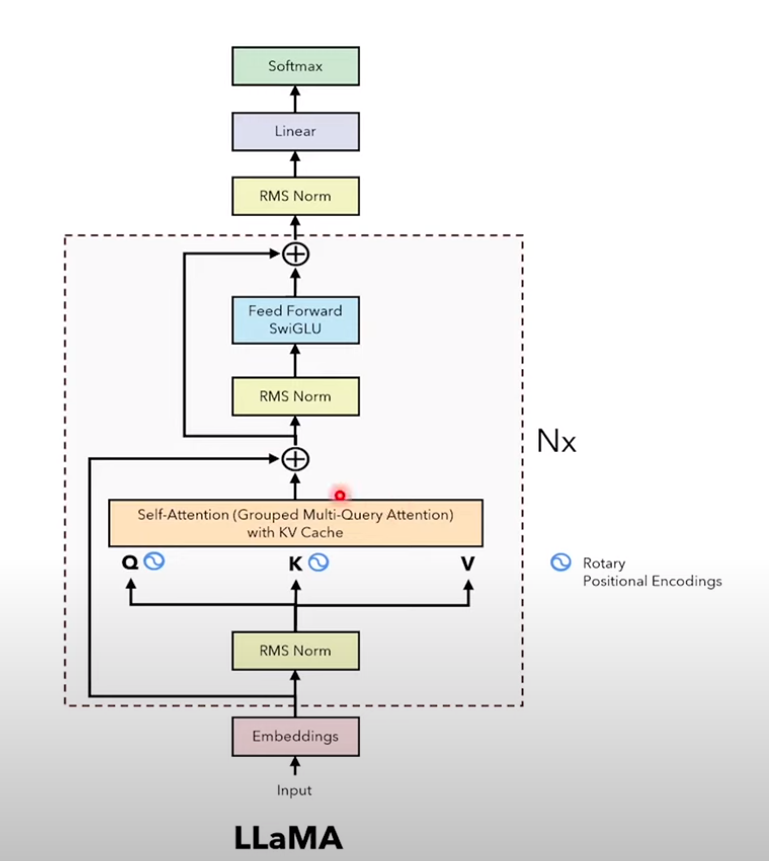

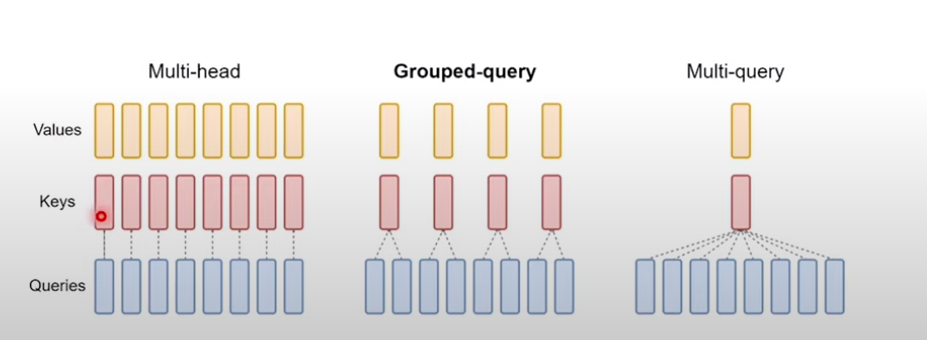

In [139]:
class RMSNorm(nn.Module):
    def __init__(self, embed_dim: int, eps: float=1e-6):
        super().__init__()
        self.eps = eps
        self.embed_dim = embed_dim
        self.gamma = nn.Parameter(torch.ones(embed_dim))

    def forward(self,x):
        # <B, Seq_Len, Embed_dim>
        # rsqrt: return 1/sqrt()
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        x = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        x = self.gamma * x
        return x   
        

In [184]:
class MultiHead_groupquery(nn.Module):
    def __init__(self, n_query_heads, n_kv_heads, embed_size, seq_len, max_seq_len, max_batch_size, dropout):
        '''
        max_seq_len: this is required to set the buffer for K,V cache used in inference (text generation), this is max seq len to be generated per prompt
        max_batch_size: this is required to set the buffer for K,V cache used in inference (text generation), this is max number of prompts
        '''
        super().__init__()
        
        self.max_batch_size = max_batch_size # max number of prompts, to be used for building KV cache
        self.seq_len = seq_len
        self.max_seq_len = max_seq_len
        # number of heads for query
        self.n_query_heads = n_query_heads
        # number of heads for keys and values (NOTE: in group query attention, number of heads for query can be different from keys/values)
        self.n_kv_heads = n_kv_heads
        # Indicate number of times the key,values heads should be repeated
        self.repeat_kv_heads = self.n_query_heads // self.n_kv_heads
        # dimension of each head referenced to n_query_heads
        self.head_size = embed_size // n_query_heads
        
        
        self.embed_size = embed_size
        self.dropout = dropout
        # key, query, values for all heads but in batch
        self.Wq = nn.Linear(embed_size, self.n_query_heads * self.head_size, bias=False)
        # NOTE: self.n_kv_heads * self.head_size may not be equal to self.n_query_heads * self.head_size
        self.Wk = nn.Linear(embed_size, self.n_kv_heads * self.head_size, bias=False)
        self.Wv = nn.Linear(embed_size, self.n_kv_heads * self.head_size, bias=False)        
        # output projection from forking path to residual highway
        self.Wout = nn.Linear(embed_size, embed_size, bias=False)
        
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.residual_dropout = nn.Dropout(dropout)
        
        # causal mask to ensure that attention is applied to left of the tokens
        self.register_buffer("bias", torch.tril(torch.ones(1, 1, self.seq_len, self.seq_len)))
        # K,V cache is used in Inferencing mode, max_batch_size if required to handle max num of prompts
        self.register_buffer("cache_k", torch.zeros((self.max_batch_size, self.max_seq_len, self.n_kv_heads, self.head_size)))
        self.register_buffer("cache_v", torch.zeros((self.max_batch_size, self.max_seq_len, self.n_kv_heads, self.head_size)))

    def forward(self, x: torch.Tensor, freqs_complex, start_pos = None):
        #print(x.shape)
        batch, seq_len, c = x.size()
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim = n_query_heads * self.head_size>
        xq = self.Wq(x)
        # <B, Seq_Len, Embed_dim = n_query_heads * self.head_size> -> <B, Seq_Len, n_query_heads, self.head_size>
        xq = rearrange(xq, 'b s (nh dim) -> b s nh dim', nh=self.n_query_heads)
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, self.n_kv_heads * self.head_size>
        xk = self.Wk(x)
        # <B, Seq_Len, self.n_kv_heads * self.head_size> -> <B, Seq_Len, self.n_kv_heads, self.head_size>
        xk = rearrange(xk, 'b s (nh dim) -> b s nh dim', nh=self.n_kv_heads)
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, self.n_kv_heads * self.head_size>
        xv = self.Wv(x)
        # <B, Seq_Len, self.n_kv_heads * self.head_size> -> <B, Seq_Len, self.n_kv_heads, self.head_size>
        xv = rearrange(xv, 'b s (nh dim) -> b s nh dim', nh=self.n_kv_heads)        

        # apply ROPE (Rotational Positonal Embedding) to Query and Key
        xq = self.apply_rope(xq, freqs_complex)
        xk = self.apply_rope(xk, freqs_complex)

        # append the token to the K,V cache in inference mode only
        if start_pos is not None: # in inference mode
            self.cache_k[:batch, start_pos:start_pos + seq_len] = xk
            self.cache_v[:batch, start_pos:start_pos + seq_len] = xv
            '''
            try:
                self.cache_k[:batch, start_pos:start_pos + seq_len] = xk
                self.cache_v[:batch, start_pos:start_pos + seq_len] = xv
            except:
                pass
            finally:
                pdb.set_trace()
                pass
            '''
            # fetch all the keys and values
            keys = self.cache_k[:batch, :start_pos + seq_len]
            values = self.cache_v[:batch, :start_pos + seq_len]
        else: # train mode
            keys = xk # <B, Seq_Len, self.n_kv_heads, self.head_size>
            values = xv #<B, Seq_Len, self.n_kv_heads, self.head_size>   

        # repeat the heads for keys and values as they may be different from number of heads in queries
        # <B, Seq_Len, self.n_kv_heads, self.head_size> -> <B, Seq_Len, self.n_kv_heads*self.repeat_kv_heads, self.head_size>
        keys = self.repeat_kv(keys, self.repeat_kv_heads)
        values = self.repeat_kv(values, self.repeat_kv_heads)

        # compute attention b/w query and key
        xq = rearrange(xq, 'b t nh dim -> b nh t dim') #<B, n_query_heads, Seq_len, self.head_size>
        keys = rearrange(keys, 'b t nh dim -> b nh dim t') #<B, n_heads=n_kv_heads*repeat_kv_heads, self.head_size, Seq_len>
        values = rearrange(values, 'b t nh dim -> b nh t dim') #<B, n_heads=n_kv_heads*repeat_kv_heads, Seq_len, self.head_size>
        attn = (xq @ keys)* self.head_size**(-0.5) #B,nh,T,T
        # causal attention mask
        if start_pos is None: # in train mode
            attn = attn.masked_fill(self.bias[:,:,:seq_len,:seq_len]==0, float('-inf'))
        attn = F.softmax(attn, dim=-1) #B,nh,T,T
        attn = self.attn_dropout(attn)
        y = attn @ values # B,nh,T,T * B,nh,T,head_size -> B,nh,T,head_size
        y = rearrange(y, 'b nh t hs -> b t (nh hs)', nh=self.n_query_heads) # B, T, n_query_heads*head_size(=embed_size)

        # output projection
        y = self.Wout(y) # <B, T, embed_dim>
        y = self.residual_dropout(y) # <B, T, embed_dim>
        return y
        

    def apply_rope(self, x, freqs_complex):
        # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
        # Two consecutive values will become a single complex number
        # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2, 2)
        x = rearrange(x, 'b t nh (dim d) -> b t nh dim d', d=2)
        # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim/2) of complex numbers
        x_complex = torch.view_as_complex(x)
        # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
        # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
        freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
        # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
        # Which results in the rotation of the complex number 
        # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
        x_rotated = x_complex * freqs_complex
        # Convert the complex number back to the real number
        # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
        x_out = torch.view_as_real(x_rotated)
        # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
        x_out = rearrange(x_out, 'b t nh dim d -> b t nh (dim d)', d=2)
        return x_out


    def repeat_kv(self, x: torch.Tensor, n_rep: int) -> torch.Tensor:
        batch_size, seq_len, n_kv_heads, head_dim = x.shape
        if n_rep == 1:
            return x # (B, Seq_Len, N_KV_Heads, Head_Dim)
        return (
            # (B, Seq_Len, N_KV_Heads, 1, Head_Dim)
            x[:, :, :, None, :]
            # (B, Seq_Len, N_KV_Heads, N_Rep, Head_Dim)
            .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
            # (B, Seq_Len, N_KV_Heads * N_Rep, Head_Dim)
            .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
        )
        
        
        

In [185]:
# FF layer is W3(SiLU(W1*x)*(W2*x))
class FF(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.W1 = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W2 = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W3 = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x):
        # (B, Seq_Len, Embed_dim) --> (B, Seq_Len, Embed_dim)
        swish = F.silu(self.W1(x))
        # (B, Seq_Len, Embed_dim) --> (B, Seq_Len, Embed_dim)
        x_V = self.W2(x)
        # (B, Seq_Len, Embed_dim) * (B, Seq_Len, Embed_dim) --> (B, Seq_Len, Embed_dim)
        x = swish * x_V
        # (B, Seq_Len, Embed_dim) --> (B, Seq_Len, Embed_dim)
        x = self.W3(x)
        return x

In [186]:
class Encoder(nn.Module):

    def __init__(self, n_query_heads, n_kv_heads, embed_size, seq_len, max_seq_len, max_batch_size, dropout):
        super().__init__()

        self.norm_inp = RMSNorm(embed_dim = embed_size)
        self.sa_mhead = MultiHead_groupquery(n_query_heads, n_kv_heads, embed_size, seq_len, max_seq_len, max_batch_size, dropout)
        self.norm_post_sa = RMSNorm(embed_dim = embed_size)
        self.fflayer = FF(embed_dim = embed_size)

    def forward(self, x, freqs_complex, start_pos=None):
        inp = x
        #print(f"Encoder: {inp.shape}")
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        x = self.norm_inp(x)
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        x = self.sa_mhead(x, freqs_complex, start_pos)
        # residual pathway addition: <B, Seq_Len, Embed_dim> + <B, Seq_Len, Embed_dim>
        x = inp + x
        #
        y = x
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        x = self.norm_post_sa(x)
        # <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        x = self.fflayer(x)
        # residual pathway addition: <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        x = x + y
        return x
        

In [187]:
class Roformer(nn.Module):

    def __init__(self, n_query_heads, n_kv_heads, embed_size, seq_len, max_seq_len, max_batch_size, vocab_size, n_repeat, dropout, device, \
                tokenizer):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.tokenizer = tokenizer

        self.head_dim = embed_size // n_query_heads
        self.seq_len = seq_len
        self.device = device
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoderlayers = nn.ModuleList()
        for layer_id in range(n_repeat):
            self.encoderlayers.append(Encoder(n_query_heads, n_kv_heads, embed_size, seq_len, max_seq_len, max_batch_size, dropout))
        #self.encoder = nn.Sequential(*[Encoder(n_query_heads, n_kv_heads, embed_size, seq_len, max_batch_size, dropout) for _ in range(n_repeat)])
        self.norm = RMSNorm(embed_dim = embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size, bias=False)

        self.freqs_complex = self.precompute_theta_pos_frequencies()
        
        # The below variable are required only for inferencing
        self.max_seq_len = max_seq_len
        self.max_batch_size = max_batch_size

    def forward(self, x, start_pos=None):
        # x: <B, Seq_Len> -> <B, Seq_Len, Embed_dim>
        batch_size, seq_len = x.shape
        x = self.embedding(x)
        
        # retrieve the (m,theta) corresponding to position [start_pos, start_pos + seq_len]
        if start_pos is None: # in training/eval mode
            freqs_complex = self.freqs_complex # send the embedding dim frequencies for all sequences in the batch
        else: # for inference (prompt completion/text generation) mode
            freqs_complex = self.freqs_complex[start_pos : start_pos + seq_len] # send the embedding dim frequencies for current sequence in the batch
            
        # x: <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        for layer in self.encoderlayers:
            x = layer(x.float(), freqs_complex, start_pos)
        #x = self.encoder(x, self.freqs_complex, start_pos)
        # x: <B, Seq_Len, Embed_dim> -> <B, Seq_Len, Embed_dim>
        x = self.norm(x)
        # x: <B, Seq_Len, Embed_dim> -> <B, Seq_Len, vocab_dim>
        x = self.lm_head(x)
        return x

    def precompute_theta_pos_frequencies(self, theta_0: float = 10000.0):
        # As written in the paragraph 3.2.2 of the paper
        # >> In order to generalize our results in 2D to any xi ∈ Rd where **d is even**, [...]
        assert self.head_dim % 2 == 0, "Dimension must be divisible by 2 as ROPE is defined with even number of dimensions"
        # Build the theta parameter
        # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
        # Shape: (Head_Dim / 2)
        theta_numerator = torch.arange(0, self.head_dim, 2).float()
        # Shape: (Head_Dim / 2)
        self.thetapercomplexdim = 1.0 / (theta_0 ** (theta_numerator / self.head_dim)).to(self.device)  # (Dim / 2)
        # Construct the positions (the "m" parameter)
        # Shape: (Seq_Len)
        m = torch.arange(self.seq_len, device=self.device)
        # Multiply each theta by each position using the outer product.
        # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
        self.freqs = torch.outer(m, self.thetapercomplexdim).float()
        # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
        # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
        freqs_complex = torch.polar(torch.ones_like(self.freqs), self.freqs)
        return freqs_complex

    def text_completion(self, prompts: list[str], temperature: float = 0.6, top_p: float = 0.9, \
                    max_gen_len: Optional[int] = None):
        if max_gen_len is None:
            max_gen_len = self.max_seq_len - 1
        # Convert each prompt into tokens
        prompt_tokens = [self.tokenizer.encode(prompt) for prompt in prompts]
        # Make sure the batch size is not too large
        batch_size = len(prompt_tokens)
        # checking max_batch size since KV cache has max batch size as parameter (KV cache is used in Inferencing)
        assert batch_size <= self.max_batch_size, f"batch size must be less than or equal to {self.max_batch_size}"
        max_prompt_len = max(len(prompt) for prompt in prompt_tokens)
        # Make sure the prompt length is not larger than the maximum sequence length
        assert max_prompt_len <= self.max_seq_len, f"prompt length must be less than or equal to {self.max_seq_len}"
        total_len = min(self.max_seq_len, max_gen_len + max_prompt_len)

        # Create the list that will contain the generated tokens, along with the initial prompt tokens
        pad_id = self.tokenizer.pad_id
        tokens = torch.full((batch_size, total_len), pad_id, dtype=torch.long, device=device)
        for k, t in enumerate(prompt_tokens):
            # Populate the initial tokens with the prompt tokens
            tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device=device)

        #eos_reached = torch.tensor([False] * batch_size, device=device)
        prompt_tokens_mask = tokens != pad_id  # True if the token is a prompt token, False otherwise
        cur_iterator = tqdm(range(1, total_len), desc="Generating tokens")
        for cur_pos in cur_iterator:
            with torch.no_grad():
                logits = self(tokens[:, cur_pos - 1:cur_pos], cur_pos)
            if temperature > 0:
                # The temperature is applied before the softmax
                probs = torch.softmax(logits[:, -1] / temperature, dim=-1)
                next_token = self._sample_top_p(probs, top_p)
            else:
                # Greedily select the token with the max probability
                next_token = torch.argmax(logits[:, -1], dim=-1)

            next_token = next_token.reshape(-1)
            # Only replace token if it is a padding token
            next_token = torch.where(prompt_tokens_mask[:, cur_pos], tokens[:, cur_pos], next_token)
            tokens[:, cur_pos] = next_token
            # EOS is reached only if we found an EOS token for a padding position
            #eos_reached |= (~prompt_tokens_mask[:, cur_pos]) & (next_token == self.tokenizer.eos_id)
            #if all(eos_reached):
            #    break

        out_tokens = []
        out_text = []
        for prompt_index, current_prompt_tokens in enumerate(tokens.tolist()):
            # Cut to the EOS token, if present
            #if self.tokenizer.eos_id in current_prompt_tokens:
            #    eos_idx = current_prompt_tokens.index(self.tokenizer.eos_id)
            #    current_prompt_tokens = current_prompt_tokens[:eos_idx]
            out_tokens.append(current_prompt_tokens)
            out_text.append(self.tokenizer.decode(current_prompt_tokens))
        return (out_tokens, out_text)

    def _sample_top_p(self, probs, p):
        # (B, vocab_size)
        probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
        # (B, vocab_size)
        probs_sum = torch.cumsum(probs_sort, dim=-1)
        # (B, vocab_size)
        # (Substracting "probs_sort" shifts the cumulative sum by 1 position to the right before masking)
        mask = probs_sum - probs_sort > p
        # Zero out all the probabilities of tokens that are not selected by the Top P
        probs_sort[mask] = 0.0
        # Redistribute the probabilities so that they sum up to 1.
        probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
        # Sample a token (its index) from the top p distribution
        next_token = torch.multinomial(probs_sort, num_samples=1)
        # Get the token position in the vocabulary corresponding to the sampled index
        next_token = torch.gather(probs_idx, -1, next_token)
        return next_token

In [188]:
N_QUERY_HEADS = 8
N_KV_HEADS = 8
EMBED_SIZE = 512
SEQ_LEN = SEQ_LEN #256
MAX_SEQ_LEN = SEQ_LEN #512
MAX_BATCH_SIZE = 4
VOCAB_SIZE = tokenizer.vocabsize
N_REPEAT = 8
DROPOUT = 0.2
DEVICE = 'cuda'

In [189]:
roformer = Roformer(N_QUERY_HEADS,
                   N_KV_HEADS,
                   EMBED_SIZE,
                   SEQ_LEN,
                   MAX_SEQ_LEN,
                   MAX_BATCH_SIZE,
                   VOCAB_SIZE,
                   N_REPEAT,
                   DROPOUT,
                   DEVICE,
                   tokenizer).to(device)

In [190]:
xx = torch.randint(0,VOCAB_SIZE, size=(MAX_BATCH_SIZE, SEQ_LEN)).to(device)
print(xx.shape)
y = roformer(xx, None)
print(y.shape)

torch.Size([4, 256])
torch.Size([4, 256, 105])


- To Do
- Set up Learner
- Find Learning rate
- set up scheduler
- initialize weights
- Train
- Do text generation

In [147]:
# initialize weights of the model
def init_weights_(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d, nn.Linear)):
        init.kaiming_normal_(m.weight)

In [148]:
class SaveModel(Callback):
    order = 11
    def __init__(self, save_path="./model_wts/"):
        fc.store_attr()
        self.save_path = Path(self.save_path)
        if not self.save_path.exists():
            self.save_path.mkdir(parents=True, exist_ok=True)

    def before_fit(self, learn):
        learn.minloss = math.inf
        
    def after_epoch(self, learn):
        if learn.training:
            if learn.loss < learn.minloss:
                learn.minloss = learn.loss
                torch.save(learn.model.state_dict(), f"{self.save_path}/model_{learn.epoch}.pt")
                torch.save(learn.opt.state_dict(), f"{self.save_path}/optimizer_{learn.epoch}.pt")

In [149]:
roformer.apply(init_weights_)

Roformer(
  (embedding): Embedding(105, 512)
  (encoderlayers): ModuleList(
    (0-7): 8 x Encoder(
      (norm_inp): RMSNorm()
      (sa_mhead): MultiHead_groupquery(
        (Wq): Linear(in_features=512, out_features=512, bias=False)
        (Wk): Linear(in_features=512, out_features=512, bias=False)
        (Wv): Linear(in_features=512, out_features=512, bias=False)
        (Wout): Linear(in_features=512, out_features=512, bias=False)
        (attn_dropout): Dropout(p=0.2, inplace=False)
        (residual_dropout): Dropout(p=0.2, inplace=False)
      )
      (norm_post_sa): RMSNorm()
      (fflayer): FF(
        (W1): Linear(in_features=512, out_features=512, bias=False)
        (W2): Linear(in_features=512, out_features=512, bias=False)
        (W3): Linear(in_features=512, out_features=512, bias=False)
      )
    )
  )
  (norm): RMSNorm()
  (lm_head): Linear(in_features=512, out_features=105, bias=False)
)

In [150]:
def loss_func1(logits, targets):
    '''
    preds: (batch, seq_len, vocab_size)
    targets: (batch, seq_len)
    '''
    #pdb.set_trace()
    loss = F.cross_entropy(logits, targets)
    return loss

class LossCB(Callback):
    order = DeviceCB.order + 1
    def after_predict(self, learn):
        #pdb.set_trace()
        learn.preds = rearrange(learn.preds, 'b t c -> (b t) c')  # <B,T,C> -> <B*T,C>
        targets = learn.batch[1]
        targets = rearrange(targets, 'b t -> (b t)')  # <B,T> -> <B*T>
        learn.batch = (learn.preds, targets)
        

In [151]:
# set up dataloaders obj
dls = DataLoaders(trainloader, valloader)
# set up loss function
loss_func = F.cross_entropy
# set up learning rate initially
lr = 1e-3

In [152]:
# set up learner 
cbs = [DeviceCB(device=device), ProgressCB(plot=True), MetricsCB(MulticlassAccuracy()), LossCB()]
learn = TrainLearner(model = roformer,
               dls = dls,
               loss_func = loss_func1,
               lr = lr,
               cbs = cbs,
               opt_func = optim.AdamW)

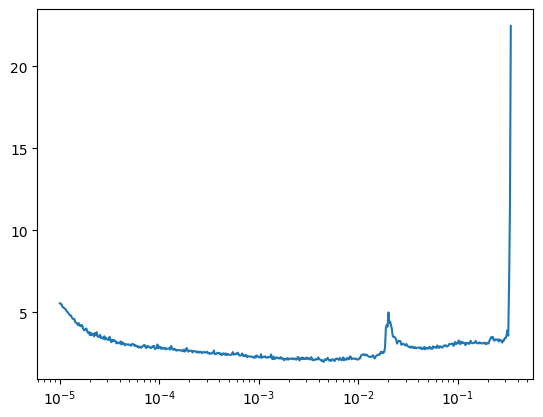

In [153]:
learn.lr_find(gamma=1.02, start_lr=1e-5, max_mult=10, max_epochs=1)

In [191]:
# empty the cuda cache
clean_ipython_hist()
clean_tb()
clean_mem()
torch.cuda.empty_cache()

- Seen above, lets fix lr=1e-4 and train with fixed learning rate

MulticlassAccuracy,loss,epoch,train
0.288,2.582,0,train
0.384,2.116,0,eval
0.435,1.915,1,train
0.472,1.781,1,eval
0.499,1.660,2,train
0.507,1.640,2,eval
0.534,1.525,3,train
0.521,1.584,3,eval
0.555,1.444,4,train
0.536,1.538,4,eval


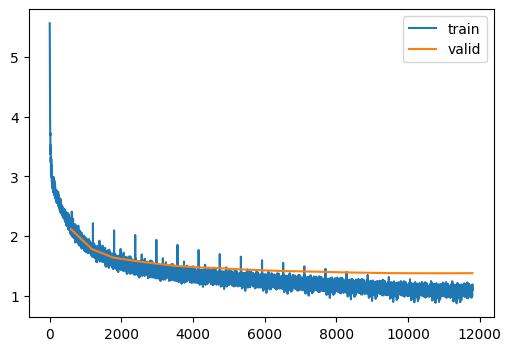

In [197]:
roformer.apply(init_weights_)
n_epochs = 20
tmax = n_epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=1e-3, total_steps=tmax)
batch_sch = BatchSchedCB(sched)
cbs = [DeviceCB(device=device), ProgressCB(plot=True), SaveModel(), MetricsCB(MulticlassAccuracy()), LossCB(), batch_sch]
learn = TrainLearner(model = roformer,
               dls = dls,
               loss_func = loss_func1,
               lr = 1e-4, #2e-5,
               cbs = cbs,
               opt_func = optim.AdamW)
learn.fit(n_epochs=n_epochs)

In [77]:
def text_completion(model, prompts: list[str], temperature: float = 0.6, top_p: float = 0.9, \
                    max_gen_len=256, max_batch_size=4, device='cuda', max_seq_len=256):
        
        # Convert each prompt into tokens
        prompt_tokens = [model.tokenizer.encode(prompt) for prompt in prompts]
        # Make sure the batch size is not too large
        batch_size = len(prompt_tokens)
        assert batch_size <= max_batch_size, f"batch size must be less than or equal to {max_batch_size}"
        max_prompt_len = max(len(prompt) for prompt in prompt_tokens)
        # Make sure the prompt length is not larger than the maximum sequence length
        assert max_prompt_len <= max_seq_len, f"prompt length must be less than or equal to {max_seq_len}"
        total_len = min(max_seq_len, max_gen_len + max_prompt_len)

        # Create the list that will contain the generated tokens, along with the initial prompt tokens
        pad_id = model.tokenizer.pad_id
        tokens = torch.full((batch_size, total_len), pad_id, dtype=torch.long, device=device)
        for k, t in enumerate(prompt_tokens):
            # Populate the initial tokens with the prompt tokens
            tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device=device)

        #eos_reached = torch.tensor([False] * batch_size, device=device)
        prompt_tokens_mask = tokens != pad_id  # True if the token is a prompt token, False otherwise
        cur_iterator = tqdm(range(1, total_len), desc="Generating tokens")
        for cur_pos in cur_iterator:
            with torch.no_grad():
                logits = model(tokens[:, cur_pos - 1:cur_pos], cur_pos)
            if temperature > 0:
                # The temperature is applied before the softmax
                probs = torch.softmax(logits[:, -1] / temperature, dim=-1)
                next_token = sample_top_p(probs, top_p)
            else:
                # Greedily select the token with the max probability
                next_token = torch.argmax(logits[:, -1], dim=-1)

            next_token = next_token.reshape(-1)
            # Only replace token if it is a padding token
            next_token = torch.where(prompt_tokens_mask[:, cur_pos], tokens[:, cur_pos], next_token)
            tokens[:, cur_pos] = next_token
            # EOS is reached only if we found an EOS token for a padding position
            #eos_reached |= (~prompt_tokens_mask[:, cur_pos]) & (next_token == self.tokenizer.eos_id)
            #if all(eos_reached):
            #    break

        out_tokens = []
        out_text = []
        for prompt_index, current_prompt_tokens in enumerate(tokens.tolist()):
            # Cut to the EOS token, if present
            #if self.tokenizer.eos_id in current_prompt_tokens:
            #    eos_idx = current_prompt_tokens.index(self.tokenizer.eos_id)
            #    current_prompt_tokens = current_prompt_tokens[:eos_idx]
            out_tokens.append(current_prompt_tokens)
            out_text.append(self.tokenizer.decode(current_prompt_tokens))
        return (out_tokens, out_text)

def sample_top_p(self, probs, p):
    # (B, vocab_size)
    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    # (B, vocab_size)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    # (B, vocab_size)
    # (Substracting "probs_sort" shifts the cumulative sum by 1 position to the right before masking)
    mask = probs_sum - probs_sort > p
    # Zero out all the probabilities of tokens that are not selected by the Top P
    probs_sort[mask] = 0.0
    # Redistribute the probabilities so that they sum up to 1.
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    # Sample a token (its index) from the top p distribution
    next_token = torch.multinomial(probs_sort, num_samples=1)
    # Get the token position in the vocabulary corresponding to the sampled index
    next_token = torch.gather(probs_idx, -1, next_token)
    return next_token

In [78]:
tokenizer.encode("\n")

[1]

In [198]:
prompts = ["\n"]
out_tokens, out_text = roformer.text_completion(prompts=prompts, max_gen_len=MAX_SEQ_LEN)

Generating tokens: 100%|████████████████████████████████████████████████████████████| 255/255 [00:01<00:00, 164.86it/s]


In [201]:
"".join(out_text[0])

'\nACT I\nScene I.\nAnother part of the Forest\n\n\nACT II\nScene I.\nAnother part of the Forest\n\n\nACT IV\nScene I.\nA Street\n\nACT II\nScene I.\nAnother part of the Field\n\n\n\n\nDramatis Personæ\n\nKING HENRY the Fourth, the Duke of York\nCONSTANCE, son to King Henry’s part '

In [202]:
prompts = ["\t"]
out_tokens, out_text = roformer.text_completion(prompts=prompts, max_gen_len=MAX_SEQ_LEN)
"".join(out_text[0])

Generating tokens: 100%|████████████████████████████████████████████████████████████| 255/255 [00:01<00:00, 181.62it/s]


'\t.\n\nPROSPERO.\nWhat, what a man hath so happy of his house?\n\nROSALIND.\nAy, and so he shall then read a creature with his head.\n\nEnter a Messenger.\n\nMOTH.\nSir, we shall have a title for you. What would you think it?\n\nEVANS.\nI am sorry to do you both.\n\nDESDEM'

In [203]:
prompts = ["\n", "Hello"]
out_tokens, out_text = roformer.text_completion(prompts=prompts, max_gen_len=MAX_SEQ_LEN)
"".join(out_text[0])

Generating tokens: 100%|████████████████████████████████████████████████████████████| 255/255 [00:01<00:00, 176.40it/s]


'\n\n\n\nACT I\n\nSCENE I. A hall in Windsor Camp near Shrewsbury.\n\n\n\n Enter Page, and Imogen and a letter.\n\nWILLIAMS.\nThe gods display the wars of a distance.\n\nSIR TOBY.\nAnd so did I.\n\nCORIOLANUS.\nMy lord, I say! The gods go with the seas,\nAnd he will be the tru'

In [204]:
"".join(out_text[1])

'Hello, if thou canst not see thee well.\n\nCASSIUS.\nO Caesar! The man is done, and leave thee how.\n\nCASSIO.\nA contagion and a man to come to thee.\n\nCOUNTESS.\nYou have not sent for me, and look not so.\n\nCASSIUS.\nYou see it at the case of France, then.\n\nCASSIU'